# **COVID-19 Detection from X-Ray Images**
*Author - M Santosh*

The following notebook implements a Deep Neural Network model, whose backbone is a Dense-Net based architecture known as CheXNet. CheXNet is a model trained on Pneumonia X-Rays, which gives better performance than radiologists. We apply transfer learning on this model to the COVID-19 dataset to detect COVID-19 from X-Ray Images. We also apply RISE (Randomized Input Sampling for Explanation of Black-box Models) to generate Saliency maps for model interpretability. 

## Dataset Sources



*   COVID-19 Chest X-Ray Dataset : https://github.com/ieee8023/covid-chestxray-dataset
*   Pneumonia Chest X-Ray Dataset : https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia
*   Pre-trained weights for CheXNet : https://github.com/arnoweng/CheXNet



We also use the Pneumonia Chest X-Ray dataset, because the class frequencies for COVID-19 dataset has fewer images for Pneumonia and Normal X-Rays. We combine them to form our dataset, which will be further split into training, validation and test sets.

## References



*   https://arxiv.org/abs/2004.12823
*   https://arxiv.org/abs/2004.09803
*   https://github.com/arnoweng/CheXNet
*   https://stanfordmlgroup.github.io/projects/chexnet/
*   https://github.com/eclique/RISE







# Imports and Data Downloading

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
import re
from shutil import copyfile
import glob
import warnings
from tqdm import tqdm_notebook as tqdm

import datetime
import json

import seaborn as sn
import pandas as pd
from scipy import interp
from itertools import cycle
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc, f1_score
from skimage.transform import resize

from PIL import Image
from pylab import rcParams
import matplotlib.pyplot as plt
import cv2

warnings.filterwarnings("ignore")
pd.set_option('max_colwidth', 1000)

## Data Downloading

The following cell clones my repo, which contains the dataset for this task. The data present in the repo is as it is downloaded from the above mentioned Data Sources and stored at one place (cannot download from Kaggle without a private API token). All the pre-processing will be done in this notebook only.

The repo also contains the pretrained weights for CheXNet Model.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/project/covid19_detection"

/content/drive/MyDrive/project/covid19_detection


In [ ]:
!git clone https://github.com/dragonsan17/covid_detection_from_xray

Cloning into 'covid_detection_from_xray'...
remote: Enumerating objects: 6148, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 6148 (delta 8), reused 0 (delta 0), pack-reused 6131
Receiving objects: 100% (6148/6148), 1.59 GiB | 17.26 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Updating files: 100% (6151/6151), done.


In [ ]:
!mkdir final_data
!mkdir final_data/train
!mkdir final_data/validation
!mkdir final_data/test

# Config

In [ ]:
CKPT_PATH = './covid_detection_from_xray/data/chexnet_pretrained'
METADATA_PATH = './covid_detection_from_xray/data/covid-chestxray-dataset/metadata.csv'

TRAIN_DATA_PATH = './final_data/train'
VAL_DATA_PATH = './final_data/validation'
TEST_DATA_PATH = './final_data/test'
SAVE_PATH = './final_data'

NORMAL_DATA_PATH = "./covid_detection_from_xray/data/NORMAL"
PNEUMONIDA_DATA_PATH = "./covid_detection_from_xray/data/PNEUMONIA"
COVID_DATA_PATH = './covid_detection_from_xray/data/covid-chestxray-dataset'

BEST_PATH = CKPT_PATH
BEST_VAL = 100000

NUM_EPOCHS_FIRST_RUN = 1 #30 Replace by 1 to see the functioning faster
NUM_EPOCHS_SECOND_RUN = 1 #10 Replace by 1 to see the functioning faster
BATCH_SIZE_FIRST_RUN = 16
BATCH_SIZE_SECOND_RUN = 4

# Data Pre-Processing

In [ ]:
img_paths = []
classes = []

## Data Reading for Normal and Pneumonia X-Rays

Reads the images from their respective folders and splits into train-val-test images

In [ ]:
for f in glob.glob(os.path.join(NORMAL_DATA_PATH, '*')):
  img_paths.append(f)
  classes.append(0)

for f in glob.glob(os.path.join(PNEUMONIDA_DATA_PATH, '*')):
  if 'bacteria' in f:
    img_paths.append(f)
    classes.append(1)
  else:
    img_paths.append(f)
    classes.append(2)

chest_xray_data = pd.DataFrame({'img_paths' : img_paths, 'classes' : classes})
chest_xray_train, chest_xray_test, _, _ = train_test_split(chest_xray_data, chest_xray_data.classes, test_size=0.3, random_state=42, stratify=chest_xray_data.classes)
chest_xray_valid, chest_xray_test, _, _ = train_test_split(chest_xray_test, chest_xray_test.classes, test_size=0.33, random_state=42, stratify=chest_xray_test.classes)

train_img_paths = list(chest_xray_train.img_paths)
train_classes = list(chest_xray_train.classes)

val_img_paths = list(chest_xray_valid.img_paths)
val_classes = list(chest_xray_valid.classes)

test_img_paths = list(chest_xray_test.img_paths)
test_classes = list(chest_xray_test.classes)

for index, row in chest_xray_train.iterrows():
  src = row.img_paths
  img_name = src.split('/')[-1]
  dst = os.path.join(TRAIN_DATA_PATH, img_name)
  copyfile(src,dst)

for index, row in chest_xray_valid.iterrows():
  src = row.img_paths
  img_name = src.split('/')[-1]
  dst = os.path.join(VAL_DATA_PATH, img_name)
  copyfile(src,dst)

for index, row in chest_xray_test.iterrows():
  src = row.img_paths
  img_name = src.split('/')[-1]
  dst = os.path.join(TEST_DATA_PATH, img_name)
  copyfile(src,dst)

## Data Reading for COVID-19 X-Rays


*   Reads the Metadata and only chooses COVID-19 images
*   Due to the presence of multiple images of same patient-id, the train-val-test split is made in such a way that same patient-id's image does not fall into train and the others, thus preventing information leakage



In [ ]:
covid_data = pd.read_csv(METADATA_PATH).fillna('')
covid_data = covid_data[((covid_data.view == 'PA') | (covid_data.view == 'AP') | (covid_data.view == 'AP Supine')) & ((covid_data.finding == 'Pneumonia/Viral/COVID-19'))]
covid_data.describe()

,patientid,offset,sex,age,finding,RT_PCR_positive,survival,intubated,intubation_present,went_icu,...,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 29
count,478,478,478,478,478,478,478,478,478,478,...,478,478,478,478,478,478,478,478,478,478
unique,295,40,3,64,1,3,3,3,3,3,...,55,100,1,478,77,215,9,342,104,1
top,250,,M,,Pneumonia/Viral/COVID-19,Y,,,,,...,2020,"Hannover Medical School, Hannover, Germany",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg,,https://github.com/ml-workgroup/covid-19-image-repository,,,,
freq,7,92,287,125,478,284,309,318,318,237,...,320,79,478,1,231,79,205,97,272,478


In [ ]:
unique_patient_ids = np.array(covid_data.patientid.unique())
patient_id_counts = []
total_samples = len(covid_data)
for patient_id in unique_patient_ids:
  count = len(covid_data[covid_data.patientid==patient_id])
  patient_id_counts.append([count, patient_id])

patient_id_counts.sort(reverse = True)

train_patient_ids = []
val_patient_ids = []
test_patient_ids = []
t_c, v_c, te_c = 0,0,0
total_count = 0
for count,id in patient_id_counts:
  total_count += count
  if total_count < 0.7*total_samples:
    train_patient_ids.append(id)
    t_c += count
  elif total_count < 0.9*total_samples:
    val_patient_ids.append(id)
    v_c += count
  else:
    test_patient_ids.append(id)
    te_c += count

print(f'Total Samples : {total_samples}')
print(f'Training Set contains {(t_c)} samples')
print(f'Validation Set contains {v_c} samples')
print(f'Test Set contains {te_c} samples')

for patient_id in train_patient_ids:
  details = covid_data[covid_data.patientid == patient_id]
  filenames = details.filename

  for filename in filenames:
    src = os.path.join(COVID_DATA_PATH, filename)
    dst = os.path.join(TRAIN_DATA_PATH, filename)
    img_paths.append(filename)
    classes.append(3)
    train_img_paths.append(filename)
    train_classes.append(3)
    copyfile(src, dst)

for patient_id in val_patient_ids:
  details = covid_data[covid_data.patientid == patient_id]
  filenames = details.filename

  for filename in filenames:
    src = os.path.join(COVID_DATA_PATH, filename)
    dst = os.path.join(VAL_DATA_PATH, filename)
    img_paths.append(filename)
    classes.append(3)
    
    val_img_paths.append(filename)
    val_classes.append(3)
    copyfile(src, dst)

for patient_id in test_patient_ids:
  details = covid_data[covid_data.patientid == patient_id]
  filenames = details.filename

  for filename in filenames:
    src = os.path.join(COVID_DATA_PATH, filename)
    dst = os.path.join(TEST_DATA_PATH, filename)
    img_paths.append(filename)
    classes.append(3)
    test_img_paths.append(filename)
    test_classes.append(3)
    copyfile(src, dst)

Total Samples : 478
Training Set contains 334 samples
Validation Set contains 96 samples
Test Set contains 48 samples


## Data-Set Class

This class will be responsible to supply data, and also has an loss function as a member, which implements binary-weighted crossentropy loss.

In [ ]:
all_data = pd.DataFrame({'img_paths' : img_paths, 'classes' : classes})
all_data.img_paths = all_data.img_paths.transform(lambda x : str(x).split('/')[-1])

train_df = pd.DataFrame({'img_paths' : train_img_paths, 'classes' : train_classes})
train_df.img_paths = train_df.img_paths.transform(lambda x : str(x).split('/')[-1])

val_df = pd.DataFrame({'img_paths' : val_img_paths, 'classes' : val_classes})
val_df.img_paths = val_df.img_paths.transform(lambda x : str(x).split('/')[-1])

test_df = pd.DataFrame({'img_paths' : test_img_paths, 'classes' : test_classes})
test_df.img_paths = test_df.img_paths.transform(lambda x : str(x).split('/')[-1])

In [ ]:
class Data_Set(Dataset):
    def __init__(self, df, rand=False, transform=None):

        self.df = df.reset_index(drop=True)
        self.rand = rand
        self.transform = transform
        self.num_normal = len(df[df.classes == 0])
        self.num_bact = len(df[df.classes == 1])
        self.num_viral = len(df[df.classes == 2])
        self.num_covid = len(df[df.classes == 3])
        self.total = len(df)
        self.loss_weight_minus = torch.FloatTensor([self.num_normal, self.num_bact, self.num_viral, self.num_covid]).unsqueeze(0).cuda() / self.total
        self.loss_weight_plus = 1.0 - self.loss_weight_minus
        
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_path = row.img_paths
        path = ''
        if os.path.exists(os.path.join(TRAIN_DATA_PATH, img_path)):
          path = os.path.join(TRAIN_DATA_PATH, img_path)
        elif os.path.exists(os.path.join(VAL_DATA_PATH, img_path)):
          path = os.path.join(VAL_DATA_PATH, img_path)
        else:
          path = os.path.join(TEST_DATA_PATH, img_path)

        image = Image.open(path).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        label = np.zeros(4).astype(np.float32)
        label[row.classes] = 1.
        return torch.tensor(image).float(), torch.tensor(label)

    def loss(self, output, target):
        
        weight_plus = torch.autograd.Variable(self.loss_weight_plus.repeat(1, target.size(0)).view(-1, self.loss_weight_plus.size(1)).cuda())
        weight_neg = torch.autograd.Variable(self.loss_weight_minus.repeat(1, target.size(0)).view(-1, self.loss_weight_minus.size(1)).cuda())

        loss = output
        pmask = (target >= 0.5).data
        nmask = (target < 0.5).data
        
        epsilon = 1e-15
        loss[pmask] = (loss[pmask] + epsilon).log() * weight_plus[pmask]
        loss[nmask] = (1-loss[nmask] + epsilon).log() * weight_plus[nmask]
        loss = -loss.sum()
        return loss

In [ ]:
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
img_transform=transforms.Compose([transforms.Resize(256),
                                    transforms.TenCrop(224),
                                    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
                                    transforms.Lambda(lambda crops: torch.stack([normalize(crop) for crop in crops]))
                                ])

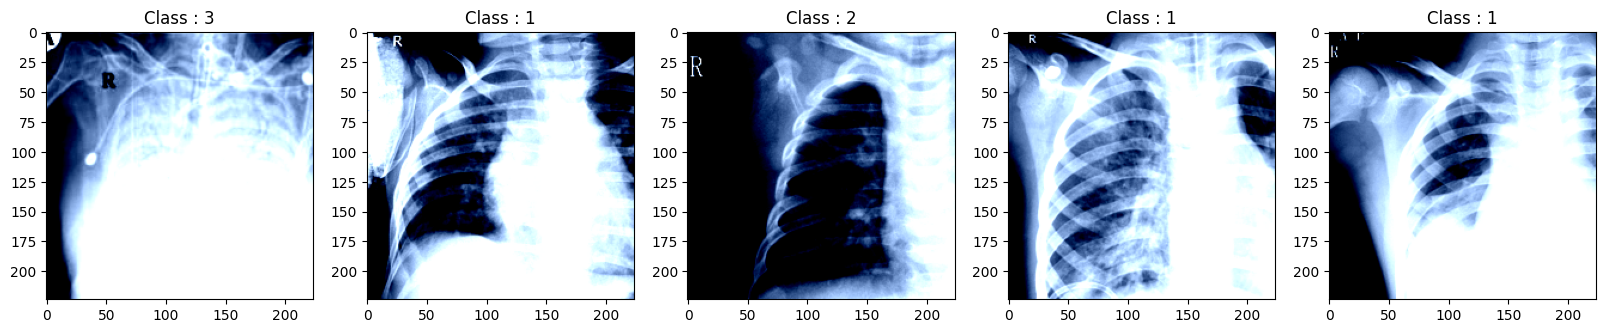

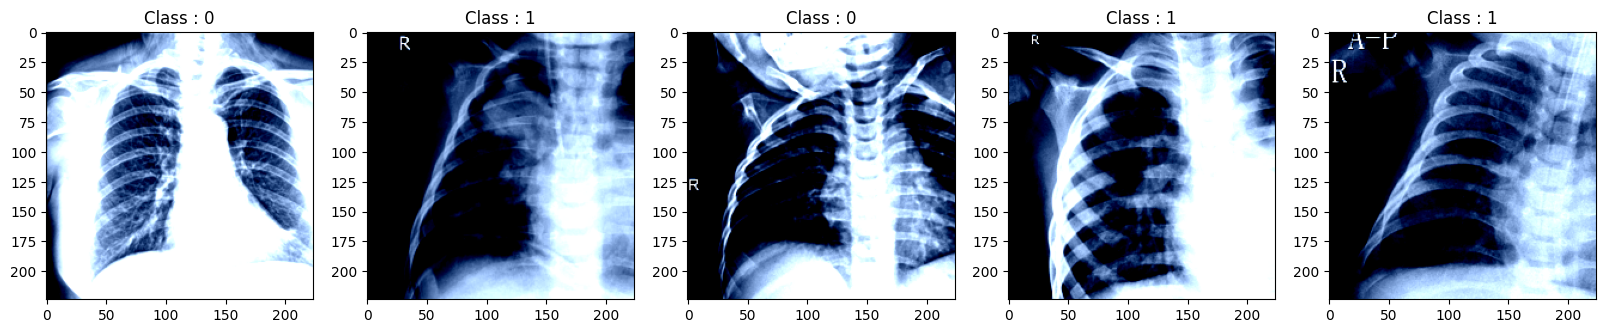

In [ ]:
#The following shows how the image is transferred to the model, after applying transforms (first crop is shown among the 10 generated)

dataset_show = Data_Set(transform=img_transform, df = train_df)
rcParams['figure.figsize'] = 20,10
for i in range(2):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        img = img[0]
        label = label.numpy().argmax()
        axarr[p].imshow((img.transpose(0, 1).transpose(1,2).squeeze()))
        axarr[p].set_title('Class : ' + str(label))

#  Model

CheXNet is built on DenseNet121 architecture, and we simply add the pretrained weights and change the final classification layer.

In [ ]:
class DenseNet121(nn.Module):
    
    def __init__(self, out_size):
        super(DenseNet121, self).__init__()
        self.densenet121 = torchvision.models.densenet121(pretrained=True)
        self.num_ftrs = self.densenet121.classifier.in_features
        self.densenet121.classifier = nn.Sequential(
            nn.Linear(self.num_ftrs, out_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.densenet121(x)
        return x

def build_model(checkpoint_path, out_features):
  model = DenseNet121(out_features).cuda()
  if checkpoint_path != '':
    model.load_state_dict(torch.load(checkpoint_path))
    if out_features == 14:
      model.densenet121.classifier = nn.Sequential(
                  nn.Linear(model.num_ftrs, 4),
                  nn.Sigmoid()
              )
  return model

torch.cuda.empty_cache()
model = build_model(CKPT_PATH, 14).cuda()

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

# Model Training

Training the model involves the following steps:



*   The pretrained CheXNet model's final classification layer is changed for 4 classes. After freezing all but this new layer, the model is trained for 30 epochs.
*   The best model of the above process in terms of validation loss is selected, and re-trained for 10 epochs after unfreezing all parameters of the model.

The best model from the second process is used for further evaluations and inference.



In [ ]:
def train(NUM_EPOCHS=10, LR=0.001, BATCH_SIZE=64, start_epoch=0, logging=True, save_path=None, freeze_feature_layers=True, detail = ''):
        
        global BEST_VAL
        global BEST_PATH

        train_dataset = Data_Set(transform=img_transform, df = train_df)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=RandomSampler(train_dataset), num_workers=4, pin_memory=True)
        val_dataset = Data_Set(transform=img_transform, df = val_df)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, sampler=RandomSampler(val_dataset), num_workers=4, pin_memory=True)
        
        if freeze_feature_layers:
            print ("Freezing feature layers")
            for param in model.densenet121.features.parameters():
                param.requires_grad = False
        else:
          for param in model.densenet121.features.parameters():
                param.requires_grad = True


        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)


        for epoch in range(start_epoch, NUM_EPOCHS):
            
            model.train()
            tot_loss = 0.0
            bar = tqdm(train_loader)
            i = 0
            for (inputs, target) in bar:
                inputs = inputs.cuda()
                target = target.cuda()

                bs, n_crops, c, h, w = inputs.size()
                inputs = inputs.view(-1, c, h, w)
                inputs = torch.autograd.Variable(inputs.view(-1, c, h, w))
                target = torch.autograd.Variable(target)
                preds = model(inputs).view(bs, n_crops, -1).mean(dim=1)

                loss = train_dataset.loss(preds, target)  
                tot_loss += float(loss.data)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                i+=1
                bar.set_description('Epoch: %.0f, Training Loss: %.5f' % (epoch+1, tot_loss/(i*BATCH_SIZE)))

            tot_loss /= len(train_df)

            torch.cuda.empty_cache()
            
            model.eval()
            val_loss = 0.0
            bar = tqdm(val_loader)
            i = 0
            for (inputs, target) in bar:
                inputs = inputs.cuda()
                target = target.cuda()

                bs, n_crops, c, h, w = inputs.size()
                inputs = inputs.view(-1, c, h, w)
                inputs = torch.autograd.Variable(inputs.view(-1, c, h, w), volatile=True)
                target = torch.autograd.Variable(target, volatile=True)

                preds = model(inputs).view(bs, n_crops, -1).mean(1)
                loss = val_dataset.loss(preds, target) 
                
                val_loss += float(loss.data)
                i+=1
                bar.set_description('Epoch: %.0f, Validation Loss: %.5f' % (epoch+1, val_loss/(i*BATCH_SIZE)))

            val_loss /= len(val_df)
            if val_loss < BEST_VAL:
              BEST_VAL = val_loss
              BEST_PATH = os.path.join(save_path, detail + 'epoch_%d.pth'%(epoch+1))

            torch.cuda.empty_cache()
            
            timestamp = str(datetime.datetime.now()).split('.')[0]
            log = json.dumps({
                'timestamp': timestamp,
                'epoch': epoch+1,
                'train_loss': float('%.5f' % tot_loss),
                'val_loss': float('%.5f' % val_loss),
                'lr': float('%.6f' % LR)
            })
            if logging:
                print(log)

            log_file = os.path.join(save_path, detail +  'train.log')
            if log_file is not None:
                with open(log_file, 'a') as f:
                    f.write("{}\n".format(log))

            model_path = os.path.join(save_path, detail + 'epoch_%d.pth'%(epoch+1))
            torch.save(model.state_dict(), model_path)
            
        print ('Finished Training, Best Model has Validation Loss: ', BEST_VAL)

In [ ]:
train(BATCH_SIZE=BATCH_SIZE_FIRST_RUN, NUM_EPOCHS=NUM_EPOCHS_FIRST_RUN, LR=1e-4, start_epoch=0, save_path=SAVE_PATH, freeze_feature_layers=True, detail = 'first_run_')

Freezing feature layers


  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

{"timestamp": "2023-04-03 08:37:25", "epoch": 1, "train_loss": 1.52169, "val_loss": 1.33464, "lr": 0.0001}
Finished Training, Best Model has Validation Loss:  1.3346422869433905


In [ ]:
torch.cuda.empty_cache()
model = build_model(BEST_PATH, 4).cuda()

In [ ]:
train(BATCH_SIZE=BATCH_SIZE_SECOND_RUN, NUM_EPOCHS=NUM_EPOCHS_SECOND_RUN, LR=1e-4, start_epoch=0, save_path=SAVE_PATH, freeze_feature_layers=False, detail = 'second_run_')

  0%|          | 0/957 [00:00<?, ?it/s]

  0%|          | 0/275 [00:00<?, ?it/s]

{"timestamp": "2023-04-03 09:01:08", "epoch": 1, "train_loss": 0.88674, "val_loss": 0.59123, "lr": 0.0001}
Finished Training, Best Model has Validation Loss:  0.5912293503383252


In [ ]:
torch.cuda.empty_cache()
model = build_model(BEST_PATH, 4).cuda()

# Model Evaluation

The following cells will evaluate the model on the test dataset, and generate ROC curves, Confusion Matrices and F-scores

In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels, cm_path):
    norm_cm = confusion_matrix(y_true, y_pred, normalize='true')
    norm_df_cm = pd.DataFrame(norm_cm, index=labels, columns=labels)
    
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.tolist()
    norm_cm = norm_cm.tolist()
    annot = [
        [("%d (%.2f)" % (c, nc)) for c, nc in zip(r, nr)]
        for r, nr in zip(cm, norm_cm)
    ]
    plt.figure(figsize = (10,7))
    sn.heatmap(norm_df_cm, annot=annot, fmt='', cbar=False, square=True, cmap=plt.cm.Blues)
    plt.xlabel("Predicted")
    plt.ylabel("Ground Truth")
    matplotlib.rcParams.update({'font.size': 14})
    plt.savefig('%s.png' % cm_path, pad_inches = 0, bbox_inches='tight')
    # print(cm)

    accuracy = np.sum(y_true == y_pred) / len(y_true)
    print("Accuracy: %.5f" % accuracy)

def compute_AUC_scores(y_true, y_pred, labels):
    AUROC_avg = roc_auc_score(y_true, y_pred)
    print('The average AUROC is {AUROC_avg:.4f}'.format(AUROC_avg=AUROC_avg))
    for y, pred, label in zip(y_true.transpose(), y_pred.transpose(), labels):
        print('The AUROC of {0:} is {1:.4f}'.format(label, roc_auc_score(y, pred)))

def plot_ROC_curve(y_true, y_pred, labels, roc_path): 
    n_classes = len(labels)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for y, pred, label in zip(y_true.transpose(), y_pred.transpose(), labels):
        fpr[label], tpr[label], _ = roc_curve(y, pred)
        roc_auc[label] = auc(fpr[label], tpr[label])

    all_fpr = np.unique(np.concatenate([fpr[label] for label in labels]))

    mean_tpr = np.zeros_like(all_fpr)
    for label in labels:
        mean_tpr += interp(all_fpr, fpr[label], tpr[label])

    mean_tpr /= n_classes

    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.figure()
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.3f})'
                ''.format(roc_auc["micro"]),
            color='deeppink', linestyle=':', linewidth=2)

    plt.plot(fpr["macro"], tpr["macro"],
            label='macro-average ROC curve (area = {0:0.3f})'
                ''.format(roc_auc["macro"]),
            color='navy', linestyle=':', linewidth=2)

    if len(labels) == 4:
        colors = ['green', 'cornflowerblue', 'darkorange', 'darkred']
    else:
        colors = ['green', 'cornflowerblue', 'darkred']
    for label, color in zip(labels, cycle(colors)):
        plt.plot(fpr[label], tpr[label], color=color, lw=lw,
                label='ROC curve of {0} (area = {1:0.3f})'
                ''.format(label, roc_auc[label]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    matplotlib.rcParams.update({'font.size': 14})
    plt.savefig('%s.png' % roc_path, pad_inches = 0, bbox_inches='tight')

In [ ]:
def predict(BATCH_SIZE=64):
    
    test_dataset = Data_Set(transform=img_transform, df = test_df)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, sampler=RandomSampler(test_dataset), num_workers=4)
    gt = torch.FloatTensor().cuda()
    pred = torch.FloatTensor().cuda()

    model.eval()
    bar = tqdm(test_loader)
    for (inputs,target) in bar:
        inputs = inputs.cuda()
        target = target.cuda()
        gt = torch.cat((gt, target), 0)

        bs, n_crops, c, h, w = inputs.size()
        inputs = torch.autograd.Variable(inputs.view(-1, c, h, w), volatile=True)

        output = model(inputs)
        output_mean = output.view(bs, n_crops, -1).mean(1)
        pred = torch.cat((pred, output_mean.data), 0)

    gt = gt.cpu().numpy()
    pred = pred.cpu().numpy()

    return gt, pred

def evaluate(BATCH_SIZE=1, cm_path='cm', roc_path='roc'):
  
  gt, pred = predict(BATCH_SIZE=BATCH_SIZE)
  
  labels = ['Normal', 'Bacterial', 'Viral', 'COVID-19']
  compute_AUC_scores(gt, pred, labels)

  plot_ROC_curve(gt, pred, labels, roc_path)

  gt = gt.argmax(axis=1)
  pred = pred.argmax(axis=1)

  plot_confusion_matrix(gt, pred, labels, cm_path)
  f1 = f1_score(gt, pred, average='macro')
  
  print("F1 Macro Score: ", f1)

  0%|          | 0/543 [00:00<?, ?it/s]

The average AUROC is 0.9463
The AUROC of Normal is 0.9971
The AUROC of Bacterial is 0.9215
The AUROC of Viral is 0.8669
The AUROC of COVID-19 is 0.9996
Accuracy: 0.82136
F1 Macro Score:  0.8314530296581595


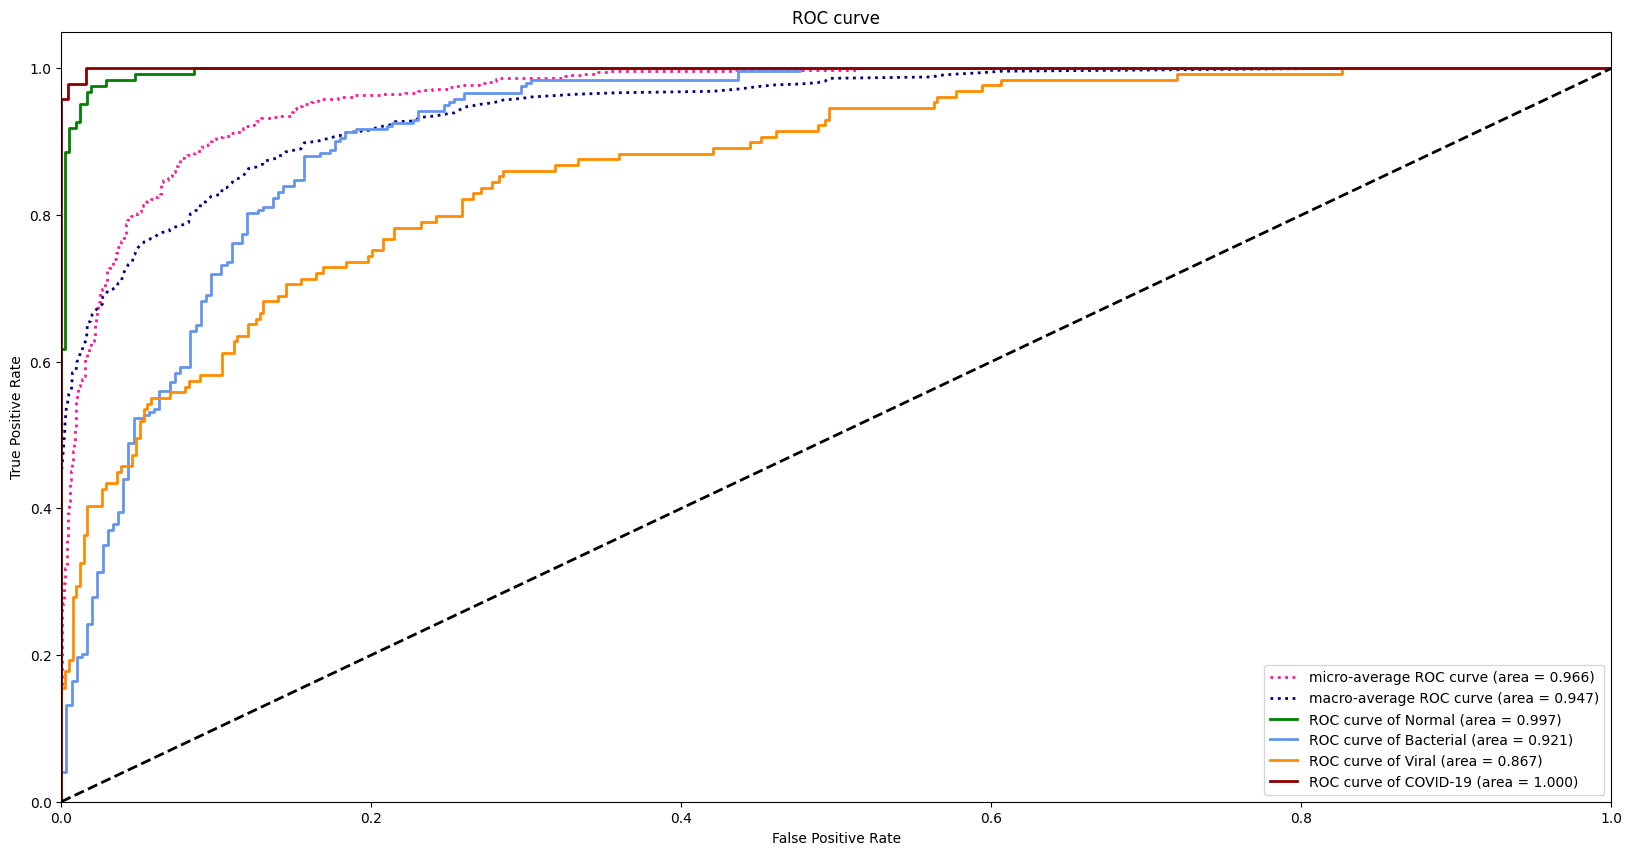

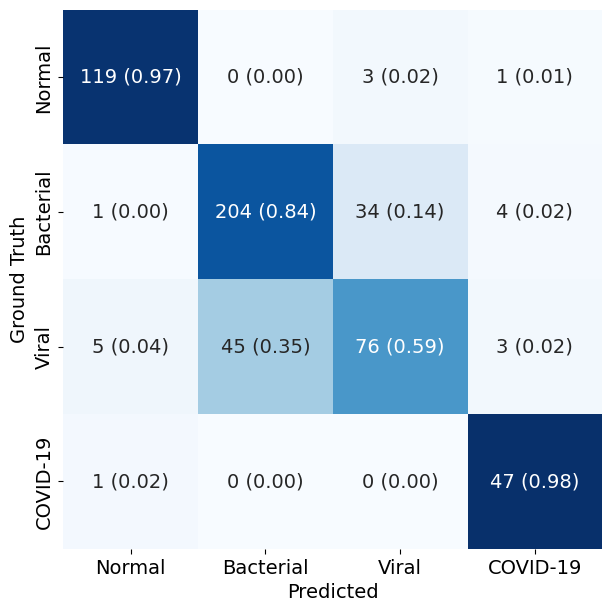

In [ ]:
evaluate(cm_path=SAVE_PATH, roc_path=SAVE_PATH)

# Model Interpretability using RISE : Randomized Input Sampling for Explanation of Black-box Models

The following will generate Saliency Maps for COVID-19 images. Red regions show regions of more importance.

In [ ]:
class RISE(nn.Module):
    def __init__(self, model, input_size, gpu_batch=100):
        super(RISE, self).__init__()
        self.model = model
        self.input_size = input_size
        self.gpu_batch = gpu_batch

    def generate_masks(self, N, s, p1, savepath='masks.npy'):
        cell_size = np.ceil(np.array(self.input_size) / s)
        up_size = (s + 1) * cell_size

        grid = np.random.rand(N, s, s) < p1
        grid = grid.astype('float32')

        self.masks = np.empty((N, *self.input_size))

        for i in tqdm(range(N), desc='Generating filters'):
            x = np.random.randint(0, cell_size[0])
            y = np.random.randint(0, cell_size[1])
            
            self.masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                         anti_aliasing=False)[x:x + self.input_size[0], y:y + self.input_size[1]]
        self.masks = self.masks.reshape(-1, 1, *self.input_size)
        np.save(savepath, self.masks)
        self.masks = torch.from_numpy(self.masks).float()
        self.masks = self.masks.cuda()
        self.N = N
        self.p1 = p1

    def load_masks(self, filepath, p1):
        self.masks = np.load(filepath)
        self.masks = torch.from_numpy(self.masks).float().cuda()
        self.N = self.masks.shape[0]
        self.p1 = p1

    def forward(self, x):
        N = self.N
        _, _, H, W = x.size()
        
        stack = torch.mul(self.masks, x.data)
        p = []
        for i in range(0, N, self.gpu_batch):
            p.append(self.model(torch.autograd.Variable(stack[i:min(i + self.gpu_batch, N)])))
        p = torch.cat(p)
        
        CL = p.size(1)
        sal = torch.matmul(p.data.transpose(0, 1), self.masks.view(N, H * W))
        sal = sal.view((CL, H, W))
        sal = sal / N / self.p1
        return sal
    
    
class RISEBatch(RISE):
    def forward(self, x):
      
        N = self.N
        B, C, H, W = x.size()
        stack = torch.mul(self.masks.view(N, 1, H, W), x.data.view(B * C, H, W))
        stack = stack.view(B * N, C, H, W)
        stack = stack

        p = []
        for i in range(0, N*B, self.gpu_batch):
            p.append(self.model(stack[i:min(i + self.gpu_batch, N*B)]))
        p = torch.cat(p)
        CL = p.size(1)
        p = p.view(N, B, CL)
        sal = torch.matmul(p.permute(1, 2, 0), self.masks.view(N, H * W))
        sal = sal.view(B, CL, H, W)
        return sal

def explain_all(data_loader, explainer):
  
    target = np.empty(len(data_loader), np.int)
    for i, (img, _) in enumerate(tqdm(data_loader, total=len(data_loader), desc='Predicting labels')):
        p, c = torch.max(model(torch.autograd.Variable(img.cuda())), dim=1)
        target[i] = c[0]

    explanations = np.empty((len(data_loader), 224,224))
    for i, (img, _) in enumerate(tqdm(data_loader, total=len(data_loader), desc='Explaining images')):
        saliency_maps = explainer(torch.autograd.Variable(img.cuda()))
        explanations[i] = saliency_maps[target[i]].cpu().numpy()
    return explanations
    
def tensor_imshow(inp, title=None, **kwargs):
    inp = inp.numpy().transpose((1, 2, 0))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp, **kwargs)
    if title is not None:
        plt.title(title)

Generating filters:   0%|          | 0/1000 [00:00<?, ?it/s]

Predicting labels:   0%|          | 0/3 [00:00<?, ?it/s]

Explaining images:   0%|          | 0/3 [00:00<?, ?it/s]

Generating visualizations:   0%|          | 0/3 [00:00<?, ?it/s]

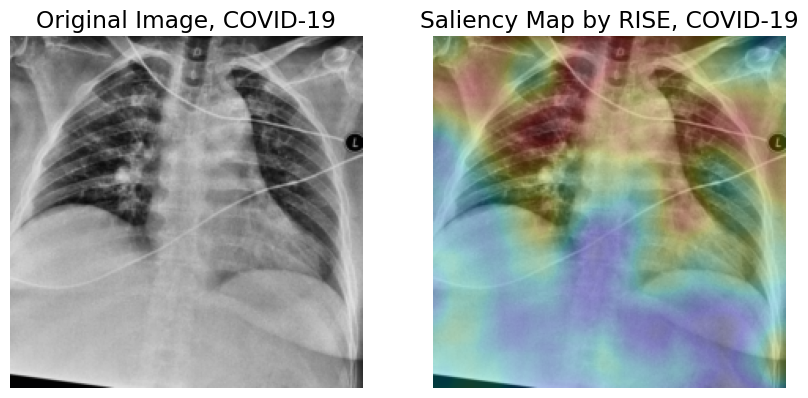

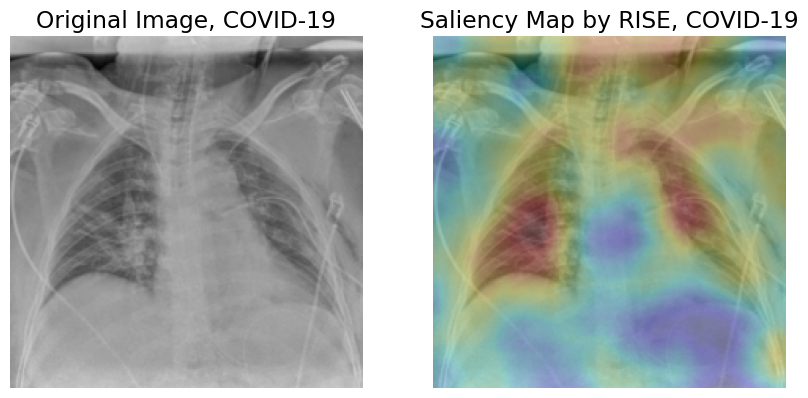

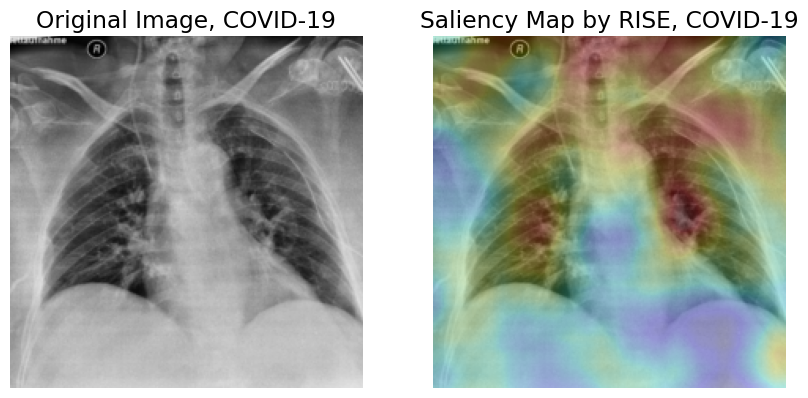

In [ ]:
preprocess = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
            ])

covid_df = train_df[train_df.classes == 3].reset_index()
explain_img_paths = covid_df['img_paths'][:3]
explain_classes = covid_df['classes'][:3]

explain_df = pd.DataFrame({'img_paths' : explain_img_paths, 'classes' : explain_classes})

dataset = Data_Set(transform=preprocess, df = explain_df)
data_loader = DataLoader(dataset, batch_size=1, num_workers=4, pin_memory=True)
gpu_batch_size = 20

model = model.eval()
model = model.cuda()

for p in model.parameters():
    p.requires_grad = False
    
explainer = RISE(model, (224,224), gpu_batch_size)

maskspath = 'masks.npy'
generate_new = True

if generate_new or not os.path.isfile(maskspath):
    explainer.generate_masks(N=1000, s=8, p1=0.1, savepath=maskspath)
else:
    explainer.load_masks(maskspath, p1=0.1)

explanations = explain_all(data_loader, explainer)

for i, (img, label) in enumerate(tqdm(data_loader, total=len(data_loader), desc='Generating visualizations')):
    p, c = torch.max(model(torch.autograd.Variable(img.cuda())), dim=1)
    p, c = p.data[0], c.data[0]

    label = label.numpy().argmax()
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.axis('off')
    tensor_imshow(img[0], 'Original Image, COVID-19')
    plt.subplot(122)
    plt.axis('off')
    tensor_imshow(img[0], 'Saliency Map by RISE, COVID-19')
    sal = explanations[i]
    plt.imshow(sal, cmap='jet', alpha=0.25)